### Requirements to use notebook:
    1. fastai environment
    2. dataset-resized file from: https://drive.google.com/open?id=0B3P9oO5A3RvSNWw5X0c5R1hJRnc
    3. personal AMLI dataset from: <to do>

## This jupyter notebook will be dedicated to training the model via the resnet34 model
Note that the **Original Trashnet Dataset (OTD)** includes only **6 classes** (no E-Waste). Therefore, we want to include E-Waste in the initial training in order to preform proper transfer learning later on.
The OTD also has a rather unique methodology that doesn't extrapolate well to our use case. Specifically, the background of every image is a white posterboard. In addition, the items themselves have been manually zoomed/cropped. (a good example is below).

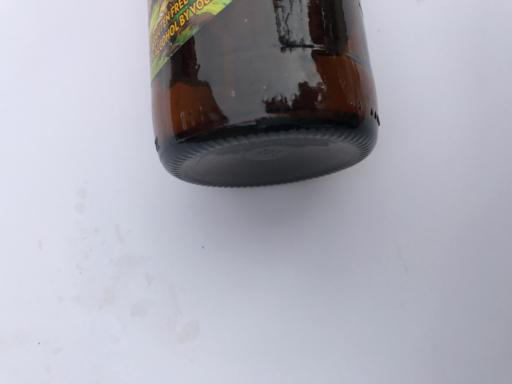

In [10]:
import os
from PIL import Image
path = os.path.join(os.getcwd(), 'dataset-resized', 'glass', 'glass298.jpg')
Image.open(path)

In order to construct a model that will not just test well (high testing accuracy), but also high use-case accuracy, we need to make sure that the images included in the dataset include a variety of images. This variety will include both white posterboard backgrounds and more natural backgrounds (as was taken in our AMLI dataset).

Let us first take a moment to explore our use-case:
    - A user will be accessing our model via an app. 
    - They will take a photo of an item they are holding in their hand, or an item they have placed down on a coun-tertop/etc. 
    - Then our model will need to both be able to distinguish the item from the background and be able to identify whether or not it is a recyclable material. 

Therefore, we need to include images with more noise in the training for our model (specifically images with noise in the background)

Note that our model will be following a similar direction as the following jupyter notebook: https://nbviewer.jupyter.org/github/collindching/Waste-Sorter/blob/master/Waste%20sorter.ipynb

# 1. Extract Data from Bucket

Please note that we are running our model through a google VM instance. Therefore, we extract our data from a bucket.

In [4]:
!gsutil ls

gs://amli_trashnet_photos/
gs://original-data-amli/


In [ ]:
!gsutil ls gs://original-data-amli/

In [6]:
!gsutil ls gs://amli_trashnet_photos/

gs://amli_trashnet_photos/AMLI-trashnet/


In [7]:
!gsutil -q cp -r gs://amli_trashnet_photos/AMLI-trashnet/ .

In [ ]:
!gsutil -q cp -r gs://original-data-amli/dataset-resized .

In [ ]:
!gsutil -q cp -r gs://original-data-amli/AMLI-trashnet/ .

In [ ]:
!gsutil -q cp -r gs://original-data-amli/AMLI-trashnet\ 2/ .

# 2. Imports and Organize images into different folders

In [8]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [1]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import cv2 as cv
import pandas as pd
import numpy as np
import os
import shutil
import random
import re
import seaborn as sns
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

At this point we have finished importing everything we will need. Next we will take the dataset-resized and separate it into a single data folder with 3 subfolders (train, valid, test). Each folder will include the classes. Note that we include E-Waste, which will be done in a separate code that will first resize all of AMLI dataset in order to both get the model to include only images of a certain size and, more importantly, filter out through images that are not readable due to individual errors.

.data
    1. train
        -> plastic
        -> paper
        -> cardboard
        -> glass
        -> metal
        -> trash
        -> E-Waste
    2. valid
        -> plastic
        -> paper
        -> cardboard
        -> glass
        -> metal
        -> trash
        -> E-Waste
     3. test
        -> plastic
        -> paper
        -> cardboard
        -> glass
        -> metal
        -> trash
        -> E-Waste

In [ ]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))


The below code will both resize and rename my dataset. This will allow for us to pass over images that may cause issues for being unreadable.

In [12]:
dataset_path = os.path.join('AMLI-trashnet')
resize_path = os.path.join('resized_AMLI')
waste_types = ['Cardboard','Glass','Metal','Paper','Plastic','Trash', 'E-Waste']
# waste_types = os.listdir(dataset_path)
# subsets = ['train','valid', 'test']
new_size = (384,512)

if not os.path.exists(resize_path):
    os.mkdir(resize_path)
    
############ Rename function ############
def rename(waste): 
    i = 0
    file_path = os.path.join(resize_path, waste)   #Remove 'Photo' since this will be called on Resized folder
    for filename in os.listdir(file_path): 
        newName = waste + str(i) + ".jpg"
        src = file_path+'/'+ filename 
        dst = file_path+ '/' + newName 
        os.rename(src, dst) 
        i += 1

############ Resize function ############
def resize(waste):
  #create categories folder in resize dataset
    file_path_1 = os.path.join(dataset_path, waste, "Photo") 
    file_path_2 = os.path.join(dataset_path, waste, 'V_Photos')
    save_path = os.path.join(resize_path, waste) 

    if not os.path.exists(save_path):
        os.mkdir(save_path)

    count = 0
    total = 0
    for filename in os.listdir(file_path_1):
        img = cv.imread(os.path.join(file_path_1,filename))
        total += 1
        if img is None:
            count += 1
            continue
        r_img = cv.resize(img, new_size)
        cv.imwrite(os.path.join(save_path,filename), r_img)
    print(waste, 'photos have', count, 'corrupted files out of', total)    
    
    count = 0
    total = 0
    for filename in os.listdir(file_path_2):
        img = cv.imread(os.path.join(file_path_2,filename))
        total += 1
        if img is None:
            count += 1
            continue
        r_img = cv.resize(img, new_size)
        cv.imwrite(os.path.join(save_path,filename), r_img)
    print(waste,'Video photos have', count, 'corrupted files out of', total)    
        
        

# subsets = ['train','valid', 'test']

for waste in waste_types:
    resize(waste) 

for waste in waste_types:
    rename(waste)

Cardboard photos have 0 corrupted files out of 141
Cardboard Video photos have 1 corrupted files out of 58
Glass photos have 1 corrupted files out of 471
Glass Video photos have 1 corrupted files out of 166
Metal photos have 0 corrupted files out of 582
Metal Video photos have 2 corrupted files out of 298
Paper photos have 14 corrupted files out of 126
Paper Video photos have 0 corrupted files out of 65
Plastic photos have 20 corrupted files out of 201
Plastic Video photos have 1 corrupted files out of 175
Trash photos have 0 corrupted files out of 285
Trash Video photos have 0 corrupted files out of 0
E-Waste photos have 2 corrupted files out of 307
E-Waste Video photos have 0 corrupted files out of 0


Let us gather a bit more information about the dataset. For example, how many of each type do we have in both the original trashnet dataset and our new AMLI dataset.

In [67]:
print('--->  original-trashnet')
original = os.path.join('dataset-resized')
class_dict = {'trash':0, 'plastic':0, 'paper':0, 'metal':0, 'glass':0, 'cardboard':0}
classes = list(class_dict.keys())
for i in classes:
    for file in os.listdir(os.path.join(original, i)):
        class_dict[i] += 1
    print(i,'has count',class_dict[i])
    
print('--->  amli-trashnet')
amli = os.path.join('AMLI-trashnet')
class_dict_amli = {'Trash':0, 'Plastic':0, 'Paper':0, 'Metal':0, 'Glass':0, 'Cardboard':0, 'E-Waste':0}
classes = list(class_dict_amli.keys())
for i in classes:
    for file in os.listdir(os.path.join(amli, i, 'Photo')):
        class_dict_amli[i] += 1
    for file in os.listdir(os.path.join(amli, i, 'V_Photos')):
        class_dict_amli[i] += 1
    print(i,'has count',class_dict_amli[i])
    
print('--->  resized_AMLI')
amli = os.path.join('resized_AMLI')
class_dict_re = {'Trash':0, 'Plastic':0, 'Paper':0, 'Metal':0, 'Glass':0, 'Cardboard':0, 'E-Waste':0}
classes = list(class_dict_re.keys())
for i in classes:
    for file in os.listdir(os.path.join(amli, i)):
        class_dict_re[i] += 1
    print(i,'has count',class_dict_re[i])    
    
print('--->  total_data')
total = os.path.join('total_data')
class_dict_total = {'Trash':0, 'Plastic':0, 'Paper':0, 'Metal':0, 'Glass':0, 'Cardboard':0, 'E-Waste':0}
classes = list(class_dict_total.keys())
for i in classes:
    for file in os.listdir(os.path.join(total, i)):
        class_dict_total[i] += 1
    print(i,'has count',class_dict_total[i])

--->  original-trashnet
trash has count 137
plastic has count 482
paper has count 594
metal has count 410
glass has count 501
cardboard has count 403
--->  amli-trashnet
Trash has count 285
Plastic has count 376
Paper has count 191
Metal has count 880
Glass has count 637
Cardboard has count 199
E-Waste has count 307
--->  resized_AMLI
Trash has count 285
Plastic has count 356
Paper has count 177
Metal has count 500
Glass has count 598
Cardboard has count 198
E-Waste has count 153
--->  total_data
Trash has count 308
Plastic has count 695
Paper has count 700
Metal has count 709
Glass has count 859
Cardboard has count 521
E-Waste has count 91


In [68]:
#let's take 60% of each class and include it into the model
def merge_data(folder):
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))
    train = random.sample(list(range(1,n+1)), int(1*n))
    return train
waste_types = ['Cardboard','Glass','Metal','Paper','Plastic','Trash', 'E-Waste']
d = {}
for waste in waste_types:
    l = merge_data(os.path.join('resized_AMLI', waste))
    d[waste] = l
    print(waste, ':', len(l))


Cardboard : 198
Glass : 598
Metal : 500
Paper : 177
Plastic : 356
Trash : 285
E-Waste : 153


In [36]:
s = 'Cardboard22.jpg'
a = s.split('.')
a[0].split('Cardboard')[1]

True

In [61]:
#Combine resized trashnet and resized AMLI in a new file called total_data
dest = 'total_data'
for waste in waste_types:
    save_path = os.path.join(dest,waste)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    #Populate it with all of original trashnet
    if(waste != 'E-Waste'):
        source = os.path.join('dataset-resized', waste.lower())
        for file in os.listdir(source):
            img = cv.imread(os.path.join(source,file))
            cv.imwrite(os.path.join(save_path,file), img)
    # Now populate it with the indices from d
    amli_source = os.path.join('resized_AMLI', waste)
    ignore = '.ipynb_checkpoints'
    count = 0
    index = 0
    for file in os.listdir(amli_source):
        index += 1
        # Using index instead of the below because it does not have any issues
        if(file == ignore):
            index -= 1
            continue
#         x = file.split('.')
#         value = int(x[0].split(waste)[1])
        if(index in d[waste]):
            count += 1
            img1 = cv.imread(os.path.join(amli_source, file))    
            cv.imwrite(os.path.join(save_path,file), img1)


In [92]:
## helper functions ##
## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## copies group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def copy_files(source_files,destination_folder):
    for file in source_files:
        img = cv.imread(file)  
        dest = os.path.join(destination_folder, file.split('/')[2])
        cv.imwrite(dest, img)

In [93]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid', 'test']
waste_types = ['Cardboard','Glass','Metal','Paper','Plastic','Trash', 'E-Waste']

In [94]:
## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('Model_data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('total_data',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "Model_data/train/"+waste_type
    copy_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "Model_data/valid/"+waste_type
    copy_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    test_dest = "Model_data/test/"+waste_type
    ## Note that the files are being copied in order to make sure our original folder does not get modified
    copy_files(test_source_files,test_dest)

In [95]:
## get a path to the folder with images
path = Path(os.getcwd())/"Model_data"
path


PosixPath('/home/jupyter/Recycling/Model_data')

Now that we have the path to our data set, we will apply some data augmentation transforms in order to increase the amount of data we can train on. Note that we are currently only flipping horizontally. This is because we have included a mix of natural backgrounds with the whiteboard backgrounds. Therefore, flipping vertically will not be representable of something the model will ever encounter. In regards to our ImageDataBunch, we use a batch size of 16 and convert all images to (384, 512).

In [164]:
tfms = get_transforms(do_flip=True)#,flip_vert=True) - NOT ADDING FLIP_VERT = TRUE BECAUSE OF E-WASTE IMAGES
# resize with size = tuple w/ resize method
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16, size = (384,512))

You can deactivate this warning by passing `no_check=True`.


/opt/anaconda3/lib/python3.7/site-packages/fastai/basic_data.py:259: UserWarning: There seems to be something wrong with your dataset, for example, in the first batch can't access these elements in self.train_ds: 1891,1322,1909,146,306...
  warn(warn_msg)


In [165]:
data

ImageDataBunch;

Train: LabelList (1928 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
Plastic,Plastic,Plastic,Plastic,Plastic
Path: /home/jupyter/Recycling/Model_data;

Valid: LabelList (953 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
Plastic,Plastic,Plastic,Plastic,Plastic
Path: /home/jupyter/Recycling/Model_data;

Test: LabelList (968 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /home/jupyter/Recycling/Model_data

In [166]:
print(data.classes)

['Cardboard', 'E-Waste', 'Glass', 'Metal', 'Paper', 'Plastic', 'Trash']


In [167]:
data.show_batch(rows=4,figsize=(10,8))

OSError: Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 99, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 99, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/opt/anaconda3/lib/python3.7/site-packages/fastai/data_block.py", line 647, in __getitem__
    if self.item is None: x,y = self.x[idxs],self.y[idxs]
  File "/opt/anaconda3/lib/python3.7/site-packages/fastai/data_block.py", line 118, in __getitem__
    if isinstance(idxs, Integral): return self.get(idxs)
  File "/opt/anaconda3/lib/python3.7/site-packages/fastai/vision/data.py", line 271, in get
    res = self.open(fn)
  File "/opt/anaconda3/lib/python3.7/site-packages/fastai/vision/data.py", line 267, in open
    return open_image(fn, convert_mode=self.convert_mode, after_open=self.after_open)
  File "/opt/anaconda3/lib/python3.7/site-packages/fastai/vision/image.py", line 393, in open_image
    x = PIL.Image.open(fn).convert(convert_mode)
  File "/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py", line 2657, in open
    % (filename if filename else fp))
OSError: cannot identify image file '/home/jupyter/Recycling/Model_data/train/Metal/Metal391.jpg'


# 3. Model Training

We will be training with a resnet34 architecture, trying to minimize the error_rate. Note that we are using a Convolutional Neural Network. This is because, although we could use a classification algorithm, CNNs have shown to outpreform classifiers in accuracy. 

In [168]:
learn = create_cnn(data,models.resnet34,metrics=error_rate)

/opt/anaconda3/lib/python3.7/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [ ]:
learn.model

## 3.1 Find the ideal learning rate
One of the hyperparameters that we can change is known as the learning rate. This number tells our model how much new information should override old information. In order to find the ideal learning rate for our model, we will plot the learning rate vs. the loss.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


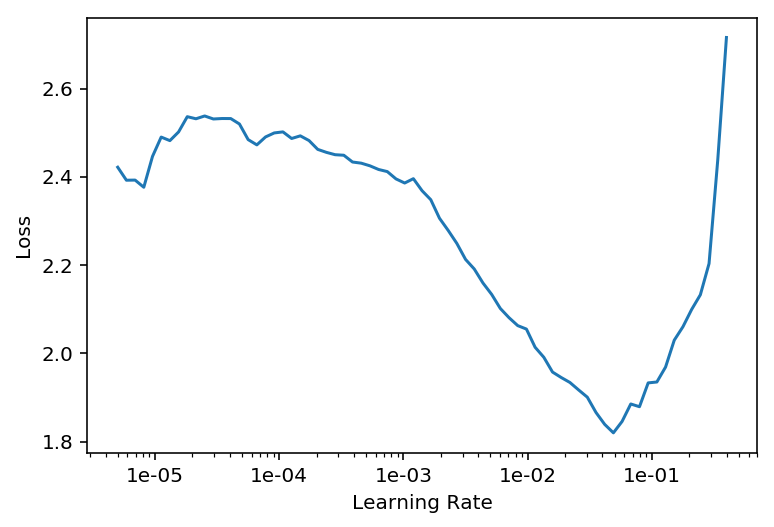

In [36]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot()

As we can see, the minimum amount of loss is inbetween 1e-02 and 1e-01. However, the minimum numerical gradient is around 5.13e-03

## 3.2 Training

In [169]:
learn.fit_one_cycle(16,max_lr=5.13e-03)
#learn.fit_one_cycle(16,max_lr=1e-01)

epoch,train_loss,valid_loss,error_rate,time


OSError: Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 99, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 99, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/opt/anaconda3/lib/python3.7/site-packages/fastai/data_block.py", line 647, in __getitem__
    if self.item is None: x,y = self.x[idxs],self.y[idxs]
  File "/opt/anaconda3/lib/python3.7/site-packages/fastai/data_block.py", line 118, in __getitem__
    if isinstance(idxs, Integral): return self.get(idxs)
  File "/opt/anaconda3/lib/python3.7/site-packages/fastai/vision/data.py", line 271, in get
    res = self.open(fn)
  File "/opt/anaconda3/lib/python3.7/site-packages/fastai/vision/data.py", line 267, in open
    return open_image(fn, convert_mode=self.convert_mode, after_open=self.after_open)
  File "/opt/anaconda3/lib/python3.7/site-packages/fastai/vision/image.py", line 393, in open_image
    x = PIL.Image.open(fn).convert(convert_mode)
  File "/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py", line 2657, in open
    % (filename if filename else fp))
OSError: cannot identify image file '/home/jupyter/Recycling/Model_data/train/Trash/Trash69.jpg'


## 3.3 VIsualizing most incorrect images¶
Although our model currently has an error rate around 0.07, it is important to understand where our model has the most issues

In [57]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

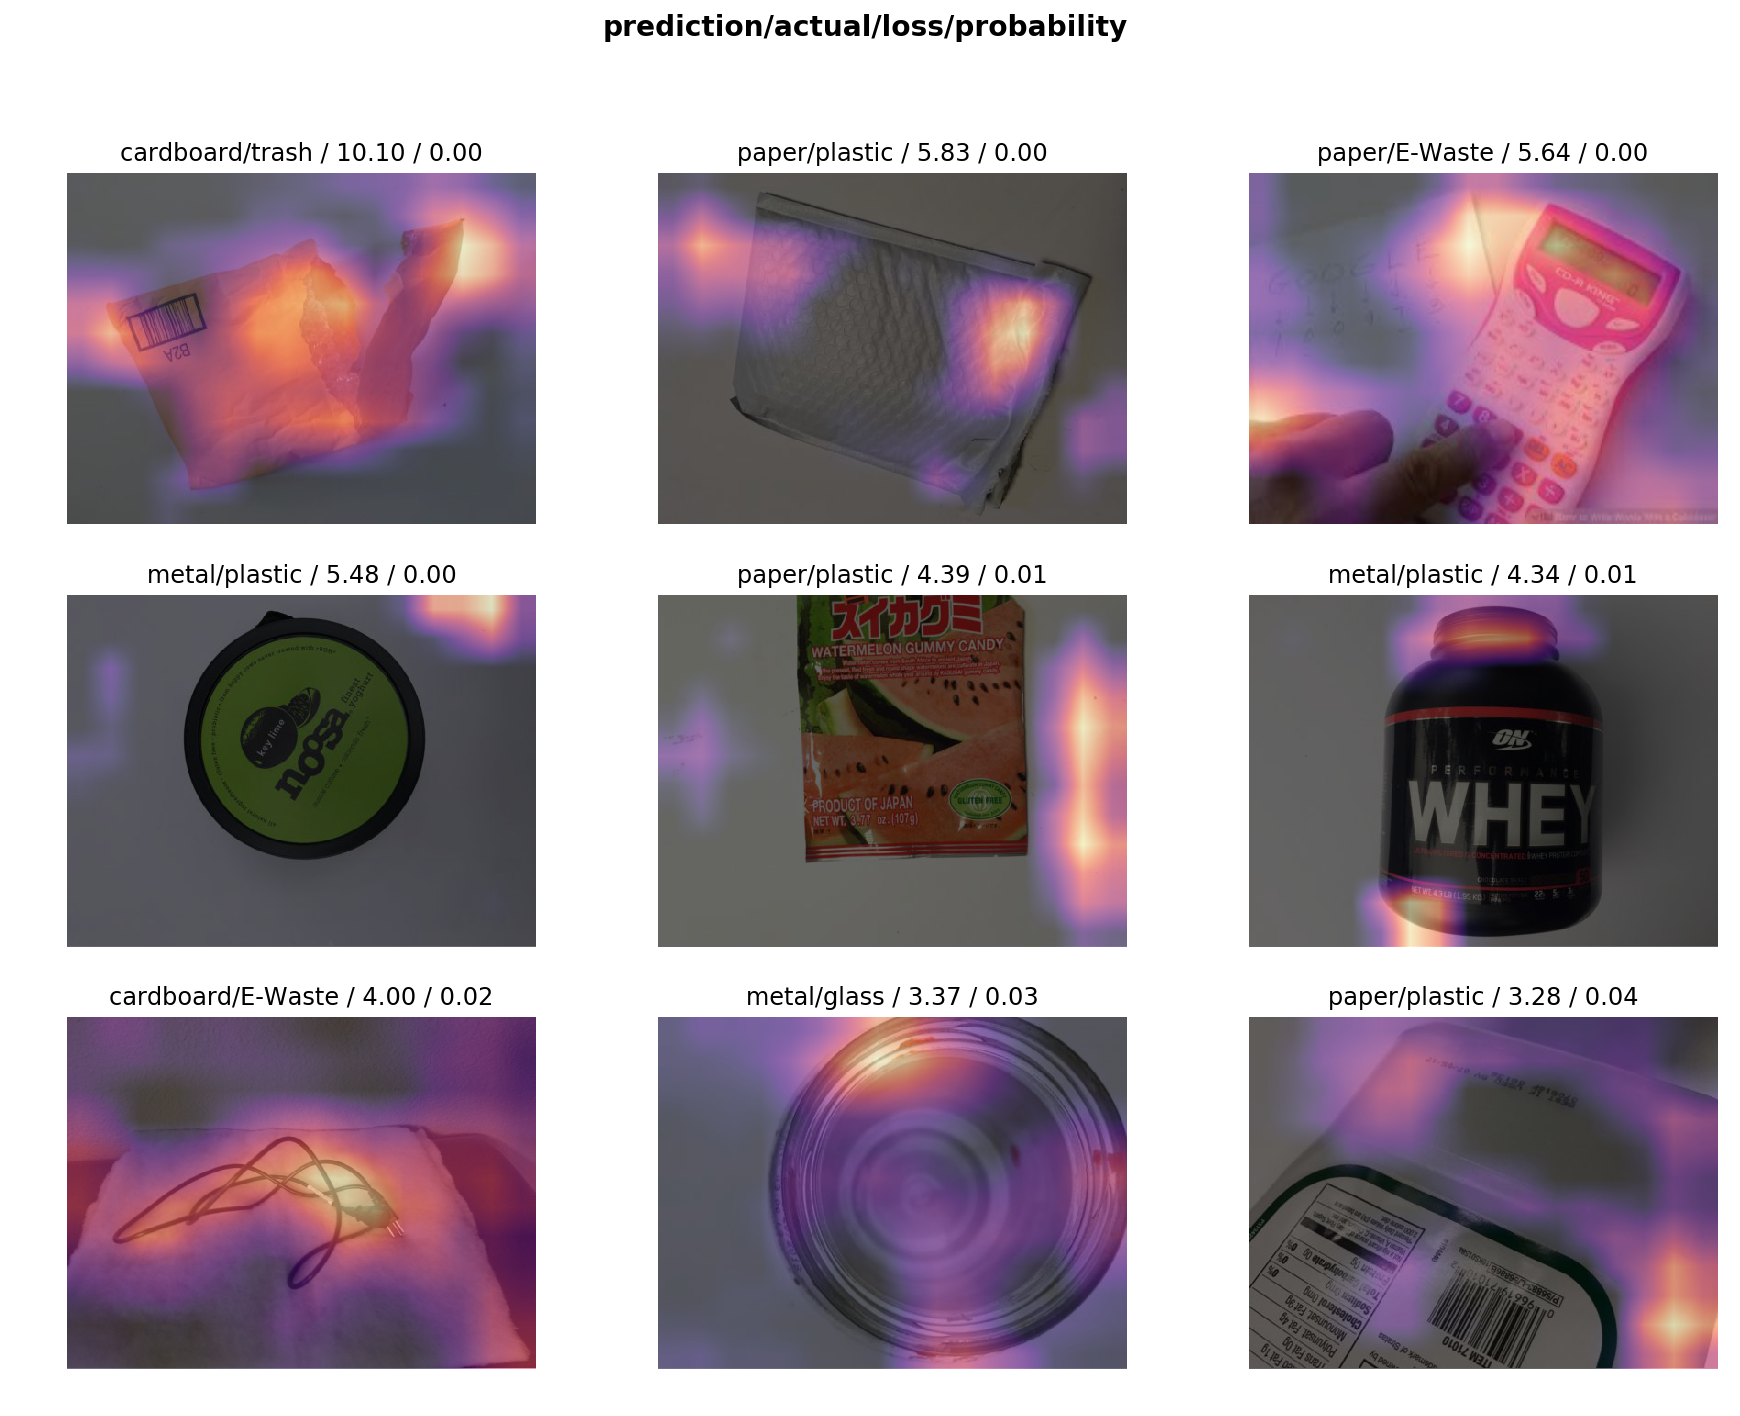

In [58]:
interp.plot_top_losses(9, figsize=(15,11))

As we can see above, the images that should have been e-waste actually included the identified material in the background.

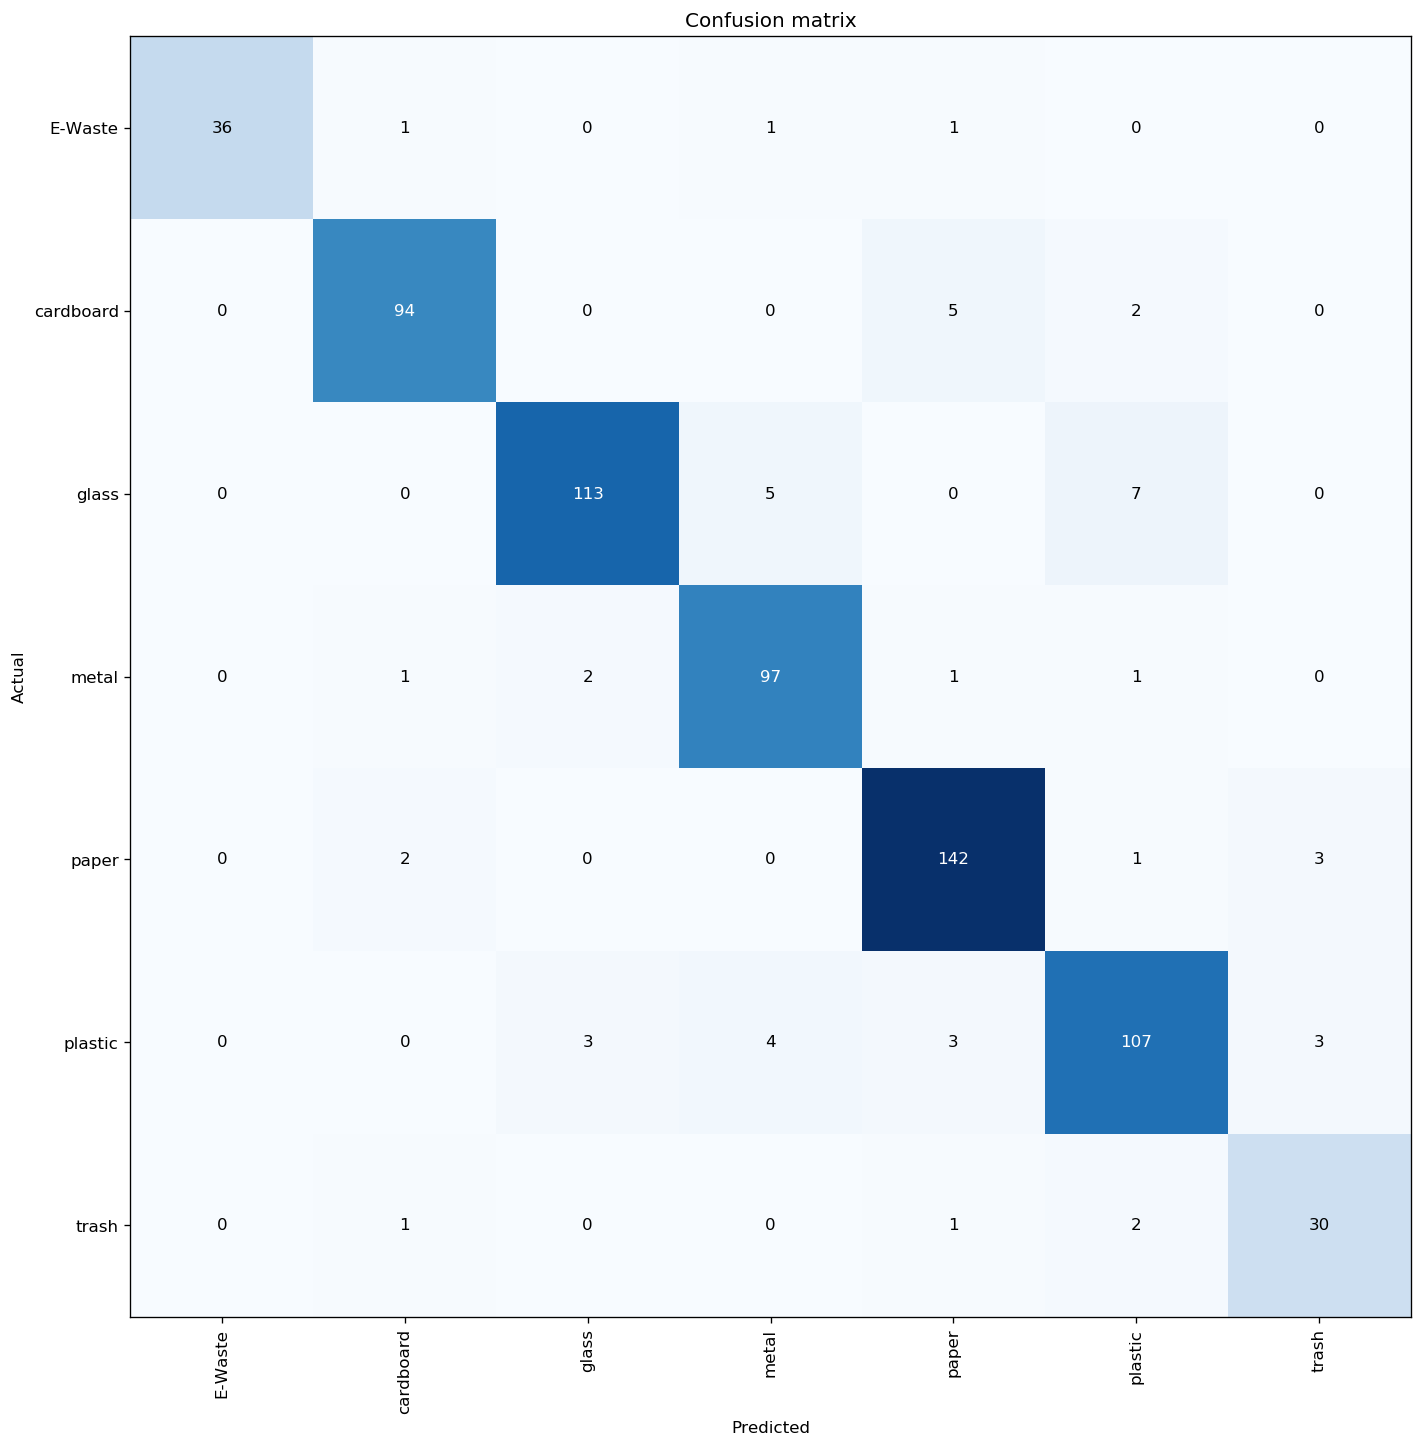

_cl_int_plot_top_losses [source] [test] _cl_int_plot_top_losses ( k , largest = True , figsize = (12, 12) , heatmap : bool = None , heatmap_thresh : int = 16 , return_fig : bool = None ) → Optional [ Figure ] 
 
 × No tests found for _cl_int_plot_top_losses . To contribute a test please refer to this guide and this discussion . Show images in top_losses along with their prediction, actual, loss, and probability of actual class. 
 Show in docs

In [59]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

As we can see, the model most often mistook both plastic and metal for glass.

In [60]:
interp.most_confused(min_val=2)

[('glass', 'plastic', 7),
 ('cardboard', 'paper', 5),
 ('glass', 'metal', 5),
 ('plastic', 'metal', 4),
 ('paper', 'trash', 3),
 ('plastic', 'glass', 3),
 ('plastic', 'paper', 3),
 ('plastic', 'trash', 3),
 ('cardboard', 'plastic', 2),
 ('metal', 'glass', 2),
 ('paper', 'cardboard', 2),
 ('trash', 'plastic', 2)]

## 3.4 Make new predictions on test data
In order to get an idea on how our model will extrapolate to our use-case, it is important to test it on the test data. Note that learn.get_preds will read a set of images (**DataSet type**) and return the respective predictiuons.

In [61]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [62]:
print(preds[0].shape)
preds[0]

torch.Size([678, 7])


tensor([[4.2184e-03, 2.8661e-02, 1.6249e-05,  ..., 9.3161e-01, 5.2384e-05,
         3.5321e-02],
        [1.2889e-02, 2.3484e-04, 2.0463e-05,  ..., 9.8625e-01, 4.0562e-04,
         1.9367e-04],
        [4.8860e-04, 7.2228e-05, 1.6448e-06,  ..., 9.9937e-01, 8.1396e-06,
         3.7493e-05],
        ...,
        [2.5959e-05, 1.9494e-04, 9.9076e-01,  ..., 9.6886e-06, 8.6784e-03,
         5.1751e-05],
        [2.4570e-05, 6.8936e-05, 9.7312e-01,  ..., 6.4058e-05, 5.7065e-03,
         3.1064e-04],
        [1.6128e-05, 4.8464e-06, 9.8374e-01,  ..., 4.9445e-07, 2.4879e-05,
         2.3660e-06]])

In [63]:
data.classes

['E-Waste', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [64]:
## saves the index (0 to 6) of the most likely (max value) class for each image
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [65]:
yhat = [] # Our predicted classes
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

In [66]:
yhat[:5]

['paper', 'paper', 'paper', 'paper', 'paper']

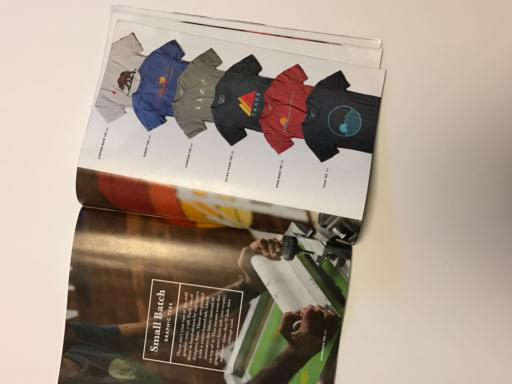

In [67]:
learn.data.test_ds[0][0]

In [68]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
        
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [69]:
## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

['paper', 'paper', 'paper', 'paper', 'paper']
['paper', 'paper', 'paper', 'paper', 'paper']


In [78]:
cm = confusion_matrix(y,yhat)

#print(cm)
# cm = cm[1:]

In [84]:
# cm = cm[:,[0,2,3,4,5,6,7]]

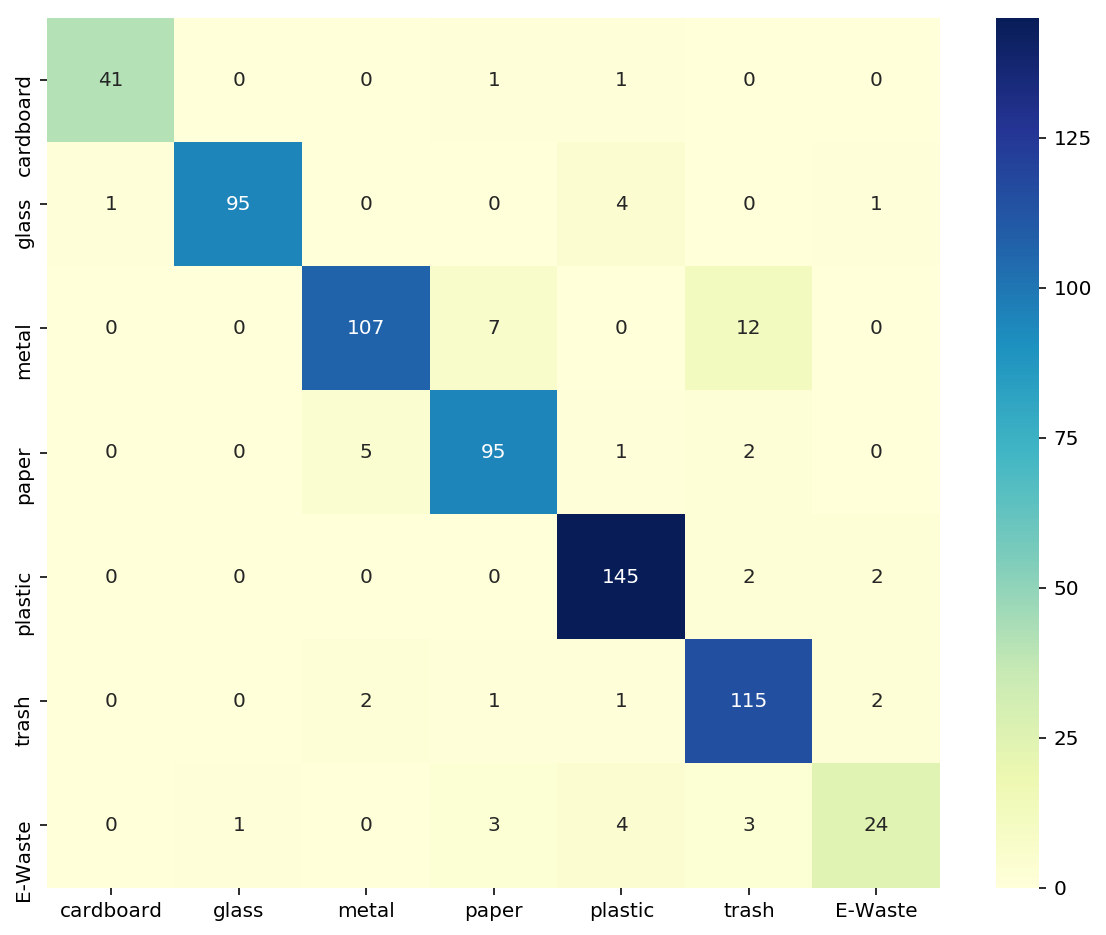

In [85]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

Our confusion matrix shows us where our model made its biggest mistakes. Our two biggest issues were: mistaking 12 trash items as metal and 7 paper items as metal.

In [86]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [87]:
accuracy = correct/sum(sum(cm))
accuracy

0.9174041297935103

As we can see, our accuracy is fairly high.

In [11]:
# ## delete everything when you're done to save space
# shutil.rmtree("data")
# shutil.rmtree('dataset-resized')

## 1.5 AMLI-trashnet Preprocessing

### Photos only first (Ignore Video folders)
Note that:
dataset-resized: includes images from the original trashnet
data: includes train,test,valid from dataset-resized
AMLI-trashnet: includes images before e-waste
new_data: includes train,test,valid from AMLI-trashnet


In [ ]:
def rename(waste): 
    i = 0
    file = os.path.join('AMLI-trashnet 2/', waste, 'Photo')
    for filename in os.listdir(file): 
        dst = waste + str(i) + ".jpg"
        src =file+'/'+ filename 
        dst =file+ '/' + dst 
        os.rename(src, dst) 
        i += 1
rename('E-Waste')

In [ ]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid', 'test']
waste_types = ['Cardboard','Glass','Metal','Paper','Plastic','Trash', 'E-Waste']

for waste in waste_types:
    rename(waste)

In [ ]:
## helper functions ##
import random
import shutil
## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(0,n))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(0,n)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.copy(file,destination_folder)

In [ ]:
## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('new_data 2',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
for waste_type in waste_types:
    source_folder = os.path.join('AMLI-trashnet 2',waste_type, 'Photo')
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    print(waste_type)
    print('train', train_ind)
    print('val', valid_ind)
    print('test', test_ind,'\n')

In [ ]:
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('AMLI-trashnet 2',waste_type, 'Photo')
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "new_data 2/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "new_data 2/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    test_dest = "new_data 2/test/"+waste_type
    move_files(test_source_files,test_dest)

In [ ]:
## get a path to the folder with images
path = Path(os.getcwd())/"new_data"
path

In [ ]:
tfms = get_transforms(do_flip=True)
data = ImageDataBunch.from_folder(path,train_pct = .5,bs=16, no_check=True)
data.classes.append('Trash')

In [ ]:
data.classes

In [ ]:
learn.data = data

In [ ]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
print(preds.shape)

In [ ]:
max_idxs = np.asarray(np.argmax(preds[0],axis=1))
print(max_idxs[7])

In [ ]:
yhat = []
for max_idx in max_idxs:
    print(max_idx)
    print(data.classes[max_idx])
    yhat.append(data.classes[max_idx])

In [ ]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [ ]:
cm = confusion_matrix(y,yhat)
print(cm)

In [ ]:
learn.data.test_ds[0][0]

In [ ]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [ ]:
accuracy = correct/sum(sum(cm))
accuracy

In [ ]:
data.classes